# Wave Analysis

**Julien Reveillon - University of Rouen Normandy**

julien.reveillon@univ-rouen.fr

www.julienreveillon.com


## Introduction
This work is designed to provide comprehensive insight into the statistical and spectral methods used to analyze wave behavior, a crucial aspect for coastal engineering, marine science, and renewable energy systems professionals.
The presented Statistical tools and techniques are essential for quantifying and predicting wave characteristics. This includes understanding wave heights, periods, and distributions, which are fundamental in assessing wave energy potential and coastal impacts.
There is also a particular focus on spectral analysis, an indispensable approach for dissecting the energy distribution of waves over different frequencies. This aspect is vital for designing and optimizing wave energy converters and understanding waves' interaction with coastal and offshore structures.

## Definitions

Fundamental terms in the study of ocean waves:
- **Wave height** $H$ [$m$]: Wave height is the vertical distance between the crest (highest point) of a wave and the trough (lowest point).
- **Surface elevation** $\eta$ [$m$]: Surface elevation refers to the height of the ocean surface at any point relative to a reference level, which is usually the still water level.
- **Surface height** $h$ [$m$]:  Surface height refers to the height of the water surface above a reference level (like the ground). 
- **Wave Length** $\lambda$ [$m$]: Wave length is a wave's horizontal distance between two consecutive crests (or troughs).
- **Period** $T$ [s]: The period of a wave is the time it takes for two successive wave crests (or troughs) to pass a fixed point.
- **Wave frequency** $f$ [$Hz$]: Wave frequency is the number of wave cycles (crests passing a point) per unit time, typically measured in cycles per second or Hertz [$Hz$]. It is inversely related to the wave period ($f = 1/T$)
- **Wave speed** or **celerity** $c$ [$m/s$]: This is the speed at which a wave crest travels. The wave speed is a function of the wave length and period and is crucial for predicting the arrival of waves at a coast or structure. For deep water waves, wave speed is proportional to the square root of the wave length.

## Preprocessing

We begin by importing the necessary Python libraries. These libraries provide a suite of tools and functions that are indispensable for data manipulation, statistical analysis, and visualization.

### Python: Import libraries

In [1]:
import os,sys
import fileinput
import numpy as np
import math, statistics
import scipy.signal as signal
import matplotlib.pyplot as plt

### Python: Define input and output data

In [2]:
#workPath='/Users/reveillo/personnel/Dropbox/7000-c-codes/wave-analysis/00-notebook'
#workPath   = '/Users/julienreveillon/Personnel/Dropbox/7000-c-codes/wave-analysis/00-notebook'
workPath   = '.'
dataPath   = workPath+'/data'
outputPath = workPath+'/output'

## Python: Define Functions

### Python : waves related functions

In [3]:
def find_waves(time, elevation, upcrossing=False):
    """
    Analyzes a wave time series to identify individual waves and their properties.
    
    Parameters:
    time (list): Timestamps corresponding to wave data points.
    elevation (list): Wave elevation data points.
    upcrossing (bool): If True, analyze using zero-upcrossing method; otherwise, use zero-downcrossing.
    
    Returns: Wave properties including heights, periods, min/max heights, and their respective times.
    """    
    # Calculate the mean of the elevation to determine the average water level
    average_elevation = statistics.mean(elevation)
    
    # Subtract the average elevatbion to center the wave data around zero
    adjusted_elevation = [d - average_elevation for d in elevation]
    
    # Determine the sign (+/-) of the elevation data
    elevation_sign = np.sign(adjusted_elevation)
    
    # Initialize lists to store wave characteristics
    wave_heights = []            # List of heights for each detected wave
    max_heights = []             # List of maximum heights for each wave
    min_heights = []             # List of minimum heights for each wave
    wave_periods = []            # List of periods for each wave
    wave_start_times = []        # List of start times for each wave
    wave_end_times = []          # List of end times for each wave
    time_at_max_height = []      # List of times when each wave reaches its maximum height
    time_at_min_height = []      # List of times when each wave reaches its minimum height
    upcross_indices = []         # Indices just before the wave goes up
    downcross_indices = []       # Indices just before the wave goes down
    upcross_times = []           # Times when each upcrossing occurs
    downcross_times = []         # Times when each downcrossing occurs
    
    # Number of data points
    num_points = len(adjusted_elevation)
    
    # Loop over each point in the elevation data
    for i in range(num_points - 1):
        # Check for a change in sign which indicates a crossing of the zero elevation
        if elevation_sign[i] * elevation_sign[i + 1] < 0:
            # Calculate the slope (alpha) for linear interpolation
            alpha = (adjusted_elevation[i + 1] - adjusted_elevation[i]) / (time[i + 1] - time[i])
            # Calculate the time at which the crossing occurs
            time_cross = time[i] - adjusted_elevation[i] / alpha
            
            # Determine if the crossing is an upcrossing or downcrossing
            if elevation_sign[i] > 0:
                downcross_indices.append(i)
                downcross_times.append(time_cross)
            else:
                upcross_indices.append(i)
                upcross_times.append(time_cross)
    
    # Process the crossings to find wave characteristics
    if upcrossing:
        # Exclude the last crossing to ensure waves are fully captured
        num_upcrosses = len(upcross_times) - 1
        
        # Analyze each wave based on upcrossings
        for i in range(num_upcrosses):
            wave_period = upcross_times[i + 1] - upcross_times[i]
            start_index = upcross_indices[i]
            end_index = upcross_indices[i + 1]
            wave_height = max(adjusted_elevation[start_index:end_index]) - min(adjusted_elevation[start_index:end_index])
            index_of_min = np.argmin(adjusted_elevation[start_index:end_index])
            index_of_max = np.argmax(adjusted_elevation[start_index:end_index])
            
            # Check the order of the max and min to ensure a proper wave
            if index_of_max < index_of_min:
                max_heights.append(average_elevation + max(adjusted_elevation[start_index:end_index]))
                min_heights.append(average_elevation + min(adjusted_elevation[start_index:end_index]))
                time_at_max_height.append(time[start_index + index_of_max])
                time_at_min_height.append(time[start_index + index_of_min])
                wave_heights.append(wave_height)
                wave_start_times.append(upcross_times[i])
                wave_end_times.append(upcross_times[i + 1])
                wave_periods.append(wave_period)
    else:
        # Exclude the last crossing for downcrossings as well
        num_downcrosses = len(downcross_times) - 1
        
        # Analyze each wave based on downcrossings
        for i in range(num_downcrosses):
            wave_period = downcross_times[i + 1] - downcross_times[i]
            start_index = downcross_indices[i]
            end_index = downcross_indices[i + 1]
            wave_height = max(adjusted_elevation[start_index:end_index]) - min(adjusted_elevation[start_index:end_index])
            index_of_min = np.argmin(adjusted_elevation[start_index:end_index])
            index_of_max = np.argmax(adjusted_elevation[start_index:end_index])
            
            # Check to ensure the minimum comes before the maximum
            if index_of_min < index_of_max:
                max_heights.append(average_elevation + max(adjusted_elevation[start_index:end_index]))
                min_heights.append(average_elevation + min(adjusted_elevation[start_index:end_index]))
                time_at_max_height.append(time[start_index + index_of_max])
                time_at_min_height.append(time[start_index + index_of_min])
                wave_heights.append(wave_height)
                wave_start_times.append(downcross_times[i])
                wave_end_times.append(downcross_times[i + 1])
                wave_periods.append(wave_period)
    
    # Return all the calculated wave characteristics
    return wave_heights,wave_periods,min_heights,max_heights,wave_start_times,wave_end_times,time_at_min_height,time_at_max_height

In [4]:
def wave_physical_properties(wave_heights, wave_periods):
    """
    Calculate physical properties of a wave set such as mean height, root mean square height,
    standard deviation of wave heights, mean height of the highest third and tenth waves, and mean period.

    Parameters:
    wave_heights (list): List of wave heights.
    wave_periods (list): List of wave periods.

    Returns:
    tuple: Mean wave height, Global height, Max height, RMS wave height, standard deviation of wave heights,
           mean of the highest third wave heights, mean of the highest tenth wave heights,
           mean period, and the number of waves.
    """
    
    # Number of waves
    num_waves = len(wave_heights)

    # H global
    global_height = max(wave_heights) - min(wave_heights)

    # H Max
    max_height = max(wave_heights)
    
    # Mean wave height
    mean_height = np.mean(wave_heights)
    
    # Calculate square of each wave height
    height_squared = [height ** 2 for height in wave_heights]
    
    # Root mean square (RMS) wave height
    rms_height = math.sqrt(np.mean(height_squared))
    
    # Standard deviation of wave heights
    deviation_height = np.std(wave_heights)
    
    # Sort the wave heights in descending order
    sorted_heights = sorted(wave_heights, reverse=True)
    
    # Mean of the highest third wave heights
    one_third_index = round(num_waves / 3)
    one_third_mean_height = np.mean(sorted_heights[:one_third_index])
    
    # Mean of the highest tenth wave heights
    one_tenth_index = round(num_waves / 10)
    one_tenth_mean_height = np.mean(sorted_heights[:one_tenth_index])
    
    # Mean wave period
    mean_period = np.mean(wave_periods)
    
    # Return the calculated physical properties
    return mean_height, global_height, max_height, rms_height, deviation_height, one_third_mean_height, one_tenth_mean_height, mean_period, num_waves

In [5]:
def wave_spectral_properties(freq, spec):
    """
    Calculates the spectral properties of waves.

    This function computes various spectral properties of a wave given its frequency 
    and spectral data. These properties include the nth moments, T01 (average period),
    Hm0 (significant wave height), maximum energy frequency, and maximum energy period.

    Args:
    freq (list): Frequency data.
    spec (list): Spectral data.

    Returns:
    tuple: nth moments, T01, Hm0, max energy frequency, max energy period.
    """

    # Determine the frequency at which the maximum energy occurs in the spectrum
    max_energy_freq = freq[np.argmax(spec)]

    # Calculate the period corresponding to the maximum energy frequency
    # If the max energy frequency is zero, set the period to zero to avoid division by zero
    max_energy_period = 1 / max_energy_freq if max_energy_freq != 0 else 0

    # Compute the first three nth moments of the spectrum
    # nth moments are a measure of the distribution of energy across frequencies
    nth_moments = [compute_nth_moment_of_spectrum(freq, spec, i) for i in range(3)]

    # Calculate T01, which is the ratio of the zeroth moment to the first moment
    # It gives an average period of the wave spectrum
    T01 = nth_moments[0] / nth_moments[1] if nth_moments[1] != 0 else 0

    # Mean zero crossing period
    T02 = math.sqrt(nth_moments[0] / nth_moments[2]) if nth_moments[2] != 0 else 0

    # Calculate Hm0, the significant wave height, as 4 times the square root of the zeroth moment
    Hm0 = 4.004 * math.sqrt(nth_moments[0])

    # Calculate Hrms Root-mean-square wave height
    Hrms = math.sqrt(8*nth_moments[0])
    

    # Return the calculated spectral properties
    return nth_moments, T01, T02, Hm0, Hrms, max_energy_freq, max_energy_period


In [6]:
def compute_nth_moment_of_spectrum(frequencies, spectrum, moment_order):
    """
    Compute the nth moment of an energy spectrum. The nth moment is a statistical property
    of the spectrum that is used to describe its shape concerning the frequency axis.
    
    Parameters:
    frequencies (array-like): The frequency axis of the spectrum, assumed to be evenly spaced.
    spectrum (array-like): The energy spectrum values corresponding to each frequency.
    moment_order (int): The order of the moment to compute. A moment_order of 0 corresponds
                        to the total energy in the spectrum.
        
    Returns:
    nth_moment (float): The computed nth moment of the energy spectrum.
    """
    
    # Calculate the frequency step from the frequency axis.
    frequency_step = frequencies[1] - frequencies[0]
    
    # Initialize the nth moment to zero.
    nth_moment = 0.0
    
    # The zeroth moment is the total area under the spectrum curve (total energy).
    if moment_order == 0:
        nth_moment = frequency_step * sum(spectrum)
    else:
        # Compute the nth moment for orders greater than 0.
        for i, frequency in enumerate(frequencies):
            nth_moment += (frequency ** moment_order) * spectrum[i] * frequency_step
    
    return nth_moment

In [7]:
def compute_wave_spectrum_welch(time, data, nBlocks):  
    """
    Compute the wave power spectral density (PSD)  with welch method
    """

    # Time step and sampling frequency.
    time_step = time[1] - time[0]
    sampling_frequency = 1 / time_step
    
    # Compute PSD
    frequencies, energy_spectrum = signal.welch(data, sampling_frequency, nperseg=nBlocks) 

    
    return (frequencies, energy_spectrum)

### Python: Files functions

In [8]:
def read_two_columns(file_path):
    """
    Read a 2-column text file while eliminating lines that begin with '#'.
    
    Args:
    file_path (str): The path to the text file.

    Returns:
    tuple: Two lists containing the data from the first and second columns, respectively.
    """
    col_one, col_two = [], []

    with fileinput.input(file_path) as file:
        for line in file:
            # Strip leading/trailing whitespace and split the line into words
            words = line.strip().split()

            # Skip empty lines and lines starting with '#'
            if words and words[0] != '#':
                col_one.append(float(words[0]))
                col_two.append(float(words[1]))

    return col_one, col_two

In [9]:
def find_closest_index(input_list, target_value):
    """
    Find the index of the closest value in the list to the target value.
    """
    array = np.asarray(input_list)
    index = (np.abs(array - target_value)).argmin()
    return index


### Stat functions

In [10]:
def calculate_pdf_cdf(data, number_of_bins, analyze_fluctuations=False):
    """
    Compute the Probability Density Function (PDF) and Cumulative Distribution Function (CDF)
    of the given data. Optionally analyze only the fluctuations around the mean.

    Parameters:
    data (array-like): The data to be analyzed, such as wave height or elevation.
    number_of_bins (int): The number of bins to use for the PDF.
    analyze_fluctuations (bool): If True, analyze the fluctuations around the mean value of the data.

    Returns:
    bin_centers (numpy array): The positions of the bin centers.
    pdf (numpy array): The PDF of the data.
    cdf (numpy array): The CDF of the data.
    poe (numpy array): The Probability of Exceedance (PoE) of the data.
    poe_Rayleigh (numpy array): The Rayleigh distribution fit for the data.
    """
    
    # Adjust the data to fluctuate around the mean if required.
    if analyze_fluctuations:
        mean_value = np.mean(data)
        fluctuating_data = [x - mean_value for x in data]
    else:
        fluctuating_data = data
    
    # Calculate the squared values and their mean for the Rayleigh distribution fit.
    squared_data = [value ** 2 for value in fluctuating_data]
    mean_squared = np.mean(squared_data)
    
    # Calculate the PDF using numpy's histogram function.
    pdf_values, bin_edges = np.histogram(fluctuating_data, bins=number_of_bins, density=True)
    
    # Determine the bin width and the bin centers.
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) * 0.5
    
    # Calculate the CDF by cumulatively summing the PDF values.
    cdf_values = np.cumsum(pdf_values) * bin_width
    
    # Calculate the Probability of Exceedance (PoE).
    poe_values = np.cumsum(pdf_values[::-1])[::-1] * bin_width
    
    # Fit a Rayleigh distribution to the data for comparison.
    poe_Rayleigh = [math.exp(-center**2 / mean_squared) for center in bin_centers]
    
    return bin_centers, pdf_values, cdf_values, poe_values, poe_Rayleigh

### Plot functions

In [11]:
def plot_wave_periods(time, elevation, num_periods):
    """
    Plots the first 'num_periods' average periods of wave data.

    Args:
    time (list): Time data for the waves.
    elevation (list): Elevation data for the waves.
    num_periods (int): Number of average periods to plot.
    """

    # Calculate initial waves and average period
    Hwaves, Twaves, Hmin, Hmax, Tstart, Tend, tHmin, tHmax = find_waves(time, elevation)

    # Find time index for the first 'num_periods' average periods
    ilp = find_closest_index(time, num_periods * np.average(Twaves))

    # Detect waves for the first 'num_periods' average periods
    Hwaves, Twaves, Hmin, Hmax, Tstart, Tend, tHmin, tHmax = find_waves(time[:ilp], elevation[:ilp])

    # Plotting
    plt.plot(time[:ilp], elevation[:ilp], '-', linewidth=2, color='indigo', zorder=20)
    plt.scatter(tHmax, Hmax, s=10, color='indigo', zorder=20)
    plt.scatter(tHmin, Hmin, s=10, color='hotpink', zorder=20)

    for i in range(len(Tstart)):
        # Plot period
        xline = [Tstart[i], Tend[i]]
        yline = [statistics.mean(elevation[:ilp]), statistics.mean(elevation[:ilp])]
        plt.plot(xline, yline, linewidth=5, alpha=0.5, zorder=30)

        # Plot crest
        w = Twaves[i] / 3
        xline = [tHmax[i] - w, tHmax[i] + w]
        yline = [Hmax[i], Hmax[i]]
        plt.plot(xline, yline, linewidth=1, color='indigo', zorder=20)

        # Plot trough
        xline = [tHmin[i] - w, tHmin[i] + w]
        yline = [Hmin[i], Hmin[i]]
        plt.plot(xline, yline, linewidth=1, color='hotpink', zorder=20)

    plt.xlabel('Time [s]', fontsize=14)
    plt.ylabel('Elevation [m]', fontsize=14)
    plt.title('Wave Detection')
    plt.grid(True)
    plt.tight_layout()


In [12]:
def plot_freq_wave(xf, yf, max_freq=-1, plot_line=True, plot_bar=False, title='Wave PSD'):
    """
    Plots the frequency wave data.

    Args:
    xf (list): X-axis data (frequency).
    yf (list): Y-axis data (spectral density).
    max_freq (float): Maximum frequency to plot. If -1, plots all data.
    plot_line (bool): If True, plots a line.
    plot_bar (bool): If True, plots bars.
    title (str): Title of the plot.
    """

    # Limit the data to the specified maximum frequency, if provided
    if max_freq > 0:
        xf, yf = zip(*[(x, y) for x, y in zip(xf, yf) if x <= max_freq])

    # Plot the data as a line or scatter plot
    if plot_line:
        plt.plot(xf, yf, '-', linewidth=2, color='indigo', zorder=20)
    else:
        plt.scatter(xf, yf, s=5, color='indigo', label='probes', zorder=20)

    # If bar is True, plot vertical lines for each data point
    if plot_bar:
        plt.vlines(xf, 0, yf, color='indigo', linewidth=10)

    # Set plot labels and title
    plt.xlabel('f [Hz]', fontsize=14)
    plt.ylabel('Spectral Density [$m^2/Hz$]', fontsize=14)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to fit all elements


In [13]:
def plot_pdf(xpdf, pdf):
    """
    Plots the Probability Density Function (PDF) for wave heights.

    Args:
    xpdf (list): x-axis data.
    pdf (list): Probability density function data.
    output_dir (str): Directory for saving plots.
    output_name (str): Name for the output file.
    notes (str): Additional notes to add to the plot title.
    """
    dx = xpdf[1] - xpdf[0]
    plt.figure()
    plt.bar(xpdf, pdf, width=0.8 * dx, color='darkorange', edgecolor='indigo', alpha=0.5)
    plt.xlabel('H [m]', fontsize=14)
    plt.ylabel('Probability Density Function P($H$)', fontsize=14)
    plt.title(f'Wave Heights $H_i$ PDF')
    plt.tight_layout()

def plot_cdf(xpdf, cdf):
    """
    Plots the Cumulative Density Function (CDF) for wave heights.

    Args:
    xpdf (list): x-axis data.
    cdf (list): Cumulative density function data.
    output_dir (str): Directory for saving plots.
    output_name (str): Name for the output file.
    notes (str): Additional notes to add to the plot title.
    """
    dx = xpdf[1] - xpdf[0]
    plt.figure()
    plt.bar(xpdf, cdf, width=0.8 * dx, color='darkorange', edgecolor='indigo', alpha=0.5)
    plt.xlabel('H [m]', fontsize=14)
    plt.ylabel('Cumulative Function C($H$)', fontsize=14)
    plt.title(f'Cumulative Function $H_i$')
    plt.tight_layout()

def plot_poe(xpdf, poe, poe_Rayleigh):
    """
    Plots the Probability of Exceedence (POE) for wave heights.

    Args:
    xpdf (list): x-axis data.
    poe (list): Probability of exceedance data.
    poe_Rayleigh (list): Probability of exceedance according to Rayleigh theory.
    output_dir (str): Directory for saving plots.
    output_name (str): Name for the output file.
    notes (str): Additional notes to add to the plot title.
    """
    dx = xpdf[1] - xpdf[0]
    plt.figure()
    plt.bar(xpdf, poe, width=0.8 * dx, color='darkorange', edgecolor='indigo', alpha=0.5, label='wave data')
    plt.plot(xpdf, poe_Rayleigh, label='Rayleigh theory')
    plt.xlabel('H [m]', fontsize=14)
    plt.ylabel('Probability of Exceedence Q($H$)', fontsize=14)
    plt.title(f'Probability of Exceedence of $H_i$')
    plt.legend(loc='upper right')
    plt.tight_layout()


## Analysis part 1 : Reading - Prepping - Detecting waves

### 1. wave elevation
The initial step in our wave analysis program involves reading the wave elevation data from a specified file. This data, potentially derived from simulations or measurements, provides the foundational information needed to analyze the behavior and characteristics of ocean waves. 

In [14]:
fileWaveData    = dataPath+'/eurotop.txt'
time,elevation  = read_two_columns(fileWaveData)
timeStep        = time[1]-time[0]
nData           = len(time)
# output
print(f'Number of data (nData)     : {nData}')
print(f'Max time. [s]              : {time[len(time)-1]:.2f}')
print(f'Timestep [s] (timeStep)    : {timeStep:.5f}')
print(f'Frequency [Hz]             : {1./timeStep:.2f}')

Number of data (nData)     : 64801
Max time. [s]              : 2160.00
Timestep [s] (timeStep)    : 0.03333
Frequency [Hz]             : 30.00


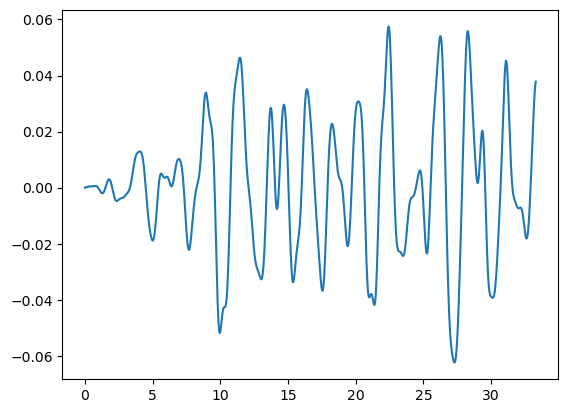

In [15]:
plt.plot(time[:1000],elevation[:1000]);

### 2. Filtering Out Non-Pertinent Data
The next task is to cleanse the data by removing any entries that lack physical relevance. This step is particularly crucial if the data originates from simulations or experiments where the water surface was initially at rest. Such initial conditions can lead to artificial or unrealistic values in the initial phase of the simulation. 

#### Vizualisation of the data to be eliminated

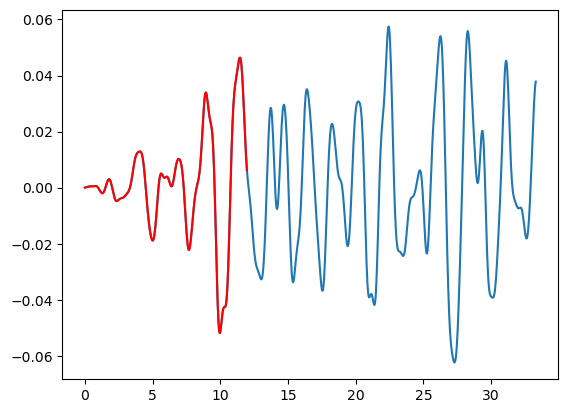

In [16]:
# select starting time (12 s) for analyze and delete previous data
index_starting = find_closest_index(time, 12)
# display in red data to be deleted
plt.plot(time[:1000],elevation[:1000])
plt.plot(time[:index_starting],elevation[:index_starting],'-r');

#### Delete the data

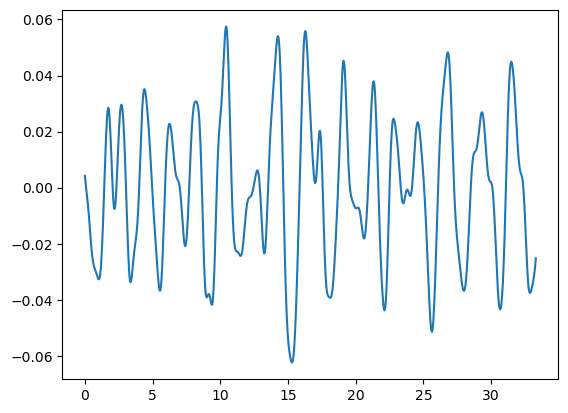

In [17]:
startingTime = time[index_starting]
time         = [t - startingTime for t in time]
time         = time[index_starting:]
elevation    = elevation[index_starting:]
nData        = len(time)
#Dispay the first 1000 data to be analyzed
plt.plot(time[:1000],elevation[:1000]);

### 3. Wave Detection through Zero-Crossing Analysis
We proceed to the wave detection phase, employing a method known as zero-crossing analysis. This technique involves identifying points where the wave elevation crosses the mean sea level (zero elevation). A zero-crossing from negative to positive indicates the start of a new wave, while a crossing from positive to negative signifies the end of a wave.

By counting these zero-crossings and analyzing the intervals between them, we can extract vital wave parameters such as wave height, period, and frequency. This method is particularly effective in distinguishing individual waves within a wave train.

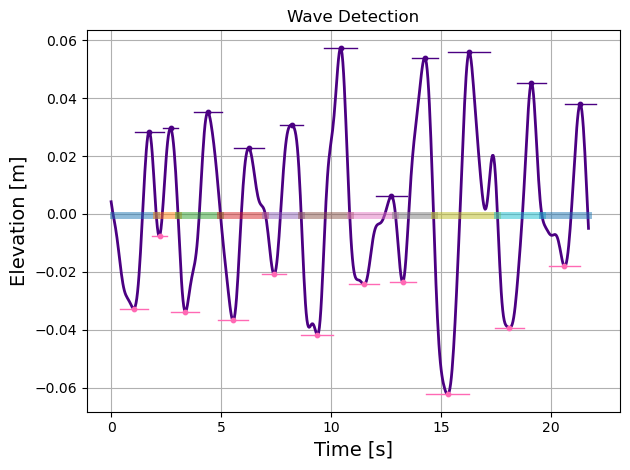

In [18]:
#
#     Plots the first 'num_periods' periods of the wave data along with the crests and troughs.
#

plot_wave_periods(time, elevation, 10)

## Analysis part 2 : Waves analysis

### 1. Physical properties analysis from the elevation signal

Parameters

In [19]:
#
#      Compute waves properties from elevation signal
#

# Detect again  all waves and average period
Hwaves,Twaves,Hmin,Hmax,Tstart,Tend,tHmin,tHmax = find_waves(time,elevation)

# Compute waves properties from elevation signal
Hmean, Hglobal, Hmax, Hrms, Hstd, H1ov3, H1ov10, Tmean, Nwaves = wave_physical_properties(Hwaves,Twaves)

#
# Output
#
print(f'phys - number of waves : {Nwaves:d} waves')
print(f'phys - Hglobal         : {Hglobal:5f} [m]')
print(f'phys - Hmax            : {Hmax:5f} [m]')
print(f'phys - Hmean           : {Hmean:5f} [m]')
print(f'phys - Hrms            : {Hrms:5f} [m]')
print(f'phys - Hstd            : {Hstd:5f} [m]')
print(f'phys - H1ov3           : {H1ov3:5f} [m]')
print(f'phys - H1ov10          : {H1ov10:5f} [m]')
print(f'phys - Tmean           : {Tmean:5f} [s]')

phys - number of waves : 981 waves
phys - Hglobal         : 0.209772 [m]
phys - Hmax            : 0.211540 [m]
phys - Hmean           : 0.077885 [m]
phys - Hrms            : 0.086533 [m]
phys - Hstd            : 0.037708 [m]
phys - H1ov3           : 0.120592 [m]
phys - H1ov10          : 0.148804 [m]
phys - Tmean           : 2.172397 [s]


### 2. Statistical analysis - PDF/CDF

In [20]:
bin_centers, pdf_values, cdf_values, poe_values, poe_Rayleigh = calculate_pdf_cdf(Hwaves,20)

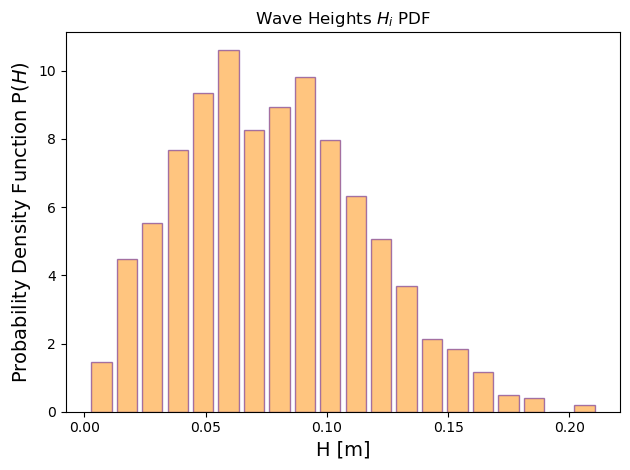

In [21]:
plot_pdf(bin_centers, pdf_values)

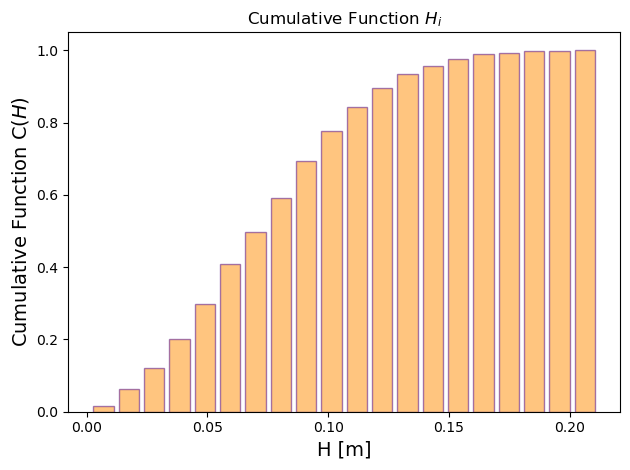

In [22]:
plot_cdf(bin_centers, cdf_values)

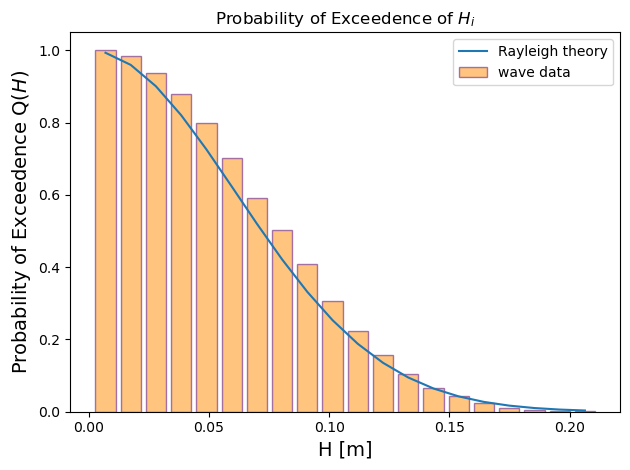

In [23]:
plot_poe(bin_centers, poe_values, poe_Rayleigh)

### 3. Power density spectrum

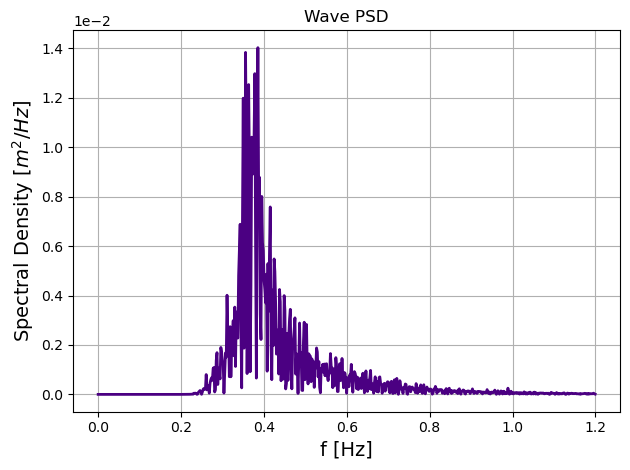

In [24]:
#
#     Power Density Spectrum
#

# if the block is too large
nBlock    = len(time)/4
freq,spec = compute_wave_spectrum_welch(time, elevation, nBlock)
plot_freq_wave(freq,spec,max_freq=1.2,plot_line=True, plot_bar=False)

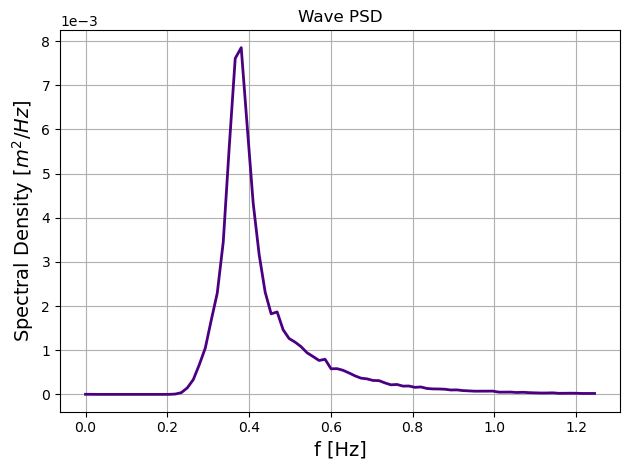

In [25]:
#
#     Power Density Spectrum BIS
#

nBlock    = 2048
freq,spec = compute_wave_spectrum_welch(time, elevation, nBlock)
plot_freq_wave(freq,spec,max_freq=1.25,plot_line=True, plot_bar=False)


### 4. Spectral analysis

#### 4.1 Characterization of the surface elevation
- First, the spectral moments can be defined $$ m_n = \int_0^\infty f^n E(f) df $$ for $n=0,1,2$ in our example. The moment $m_0$ is the variance of the surface elevation. It can be computed with the elevation signal as well. 
- Mean wave height $$H_{mean} = \sqrt{2 \pi m_0}$$
- Significant wave height $$H_s = 4 \sqrt{m_0}$$
- Root-mean-square wave height $$H_{rms} = \sqrt{8 m_0}$$
- Expected maximum wave height $$E(H_{max}) = 2 \left(1+\frac{0.29}{\ln(N)}\right) \sqrt{2\ln(N)} \sqrt{m_0}$$  
- Mean zero-crossing period $$T_0 = \sqrt{m_0/m_2}$$
- Mean wave period $$T_m = T_{01} = m_0/m_1$$
- Significant wave period $$ T_s = 1/f_{peak} $$

In [26]:
#
#     Spectral analysis
#

nth_moments, T01, T02, Hm0, Hrms, max_energy_freq, max_energy_period = wave_spectral_properties(freq,spec)
# Output
print(f'spect - freq peak energy                  : {max_energy_freq:.5f} [Hz]')
print(f'spect - significcant wave period          : {max_energy_period:.5f} [s]')
for i, mnth in enumerate(nth_moments):
    print(f'spect - m{i} momentum                       : {mnth:8.2e}')
print(f'spect - Mean wave period T01              : {T01:.5f} [s]')
print(f'spect - Mean zero crossing period T02     : {T02:.5f} [s]')
print(f'spect - Significant wave height Hm0       : {Hm0:.5f} [m]')
print(f'spect - Root-mean-square wave height Hrms : {Hrms:.5f} [m]')

spect - freq peak energy                  : 0.38086 [Hz]
spect - significcant wave period          : 2.62561 [s]
spect - m0 momentum                       : 9.68e-04
spect - m1 momentum                       : 4.29e-04
spect - m2 momentum                       : 2.13e-04
spect - Mean wave period T01              : 2.25711 [s]
spect - Mean zero crossing period T02     : 2.13156 [s]
spect - Significant wave height Hm0       : 0.12460 [m]
spect - Root-mean-square wave height Hrms : 0.08802 [m]
